In [1]:
# Author: Roshan Ram
# AndrewID: rram

import yfinance as yfinance

import module_manager
module_manager.review()

import yfinance as yf # to pull stock data with yf.download(name, yyyy-mm-dd of opening, yyyy-mm-dd of opening)

import numpy as np # used for everything lol
import pandas as pd # data mainpulation
import matplotlib.pyplot as plt # graphing/plotting
from keras import *


#####
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
####

%matplotlib inline 
#just to make stuff look nice

Using TensorFlow backend.


In [2]:
stock = None
while not isinstance(stock, str):
    stock = input("Enter your desired stock. Only alphanumeric characters please.")
openingInp = input("Enter your desired opening date. (yyyy-mm-dd)") #'2016-01-01'
closingInp = input("Enter your desired closing date. (yyyy-mm-dd)") # '2019-08-01'


data = yf.download(stock, openingInp, closingInp)

Enter your desired stock. Only alphanumeric characters please.AAPL
Enter your desired opening date. (yyyy-mm-dd)2016-08-01
Enter your desired closing date. (yyyy-mm-dd)2019-11-01
[*********************100%***********************]  1 of 1 completed


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

TIME_STEPS = 10 # [rram]
BATCH_SIZE = 32 # [rram]


#####
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

# INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
OUTPUT_PATH = '~/Desktop'
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
###


train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 656 165


In [4]:

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in (range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [5]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [6]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (596, 60, 5) (596,)
length of time-series i/o (105, 60, 5) (105,)


In [7]:
# def create_model():
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.00010000)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [8]:
model = lstm_model

In [9]:

csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

# epochs = params['epochs']

history = model.fit(x_t, y_t, epochs= 300, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE))) #callbacks=[csv_logger])

# history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
#                         shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                         trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])

Train on 580 samples, validate on 40 samples
Epoch 1/300
 - 2s - loss: 0.0519 - val_loss: 0.0687
Epoch 2/300
 - 1s - loss: 0.0494 - val_loss: 0.0567
Epoch 3/300
 - 1s - loss: 0.0475 - val_loss: 0.0475
Epoch 4/300
 - 1s - loss: 0.0459 - val_loss: 0.0389
Epoch 5/300
 - 1s - loss: 0.0441 - val_loss: 0.0308
Epoch 6/300
 - 1s - loss: 0.0426 - val_loss: 0.0234
Epoch 7/300
 - 1s - loss: 0.0401 - val_loss: 0.0175
Epoch 8/300
 - 1s - loss: 0.0387 - val_loss: 0.0128
Epoch 9/300
 - 1s - loss: 0.0362 - val_loss: 0.0095
Epoch 10/300
 - 1s - loss: 0.0335 - val_loss: 0.0076
Epoch 11/300
 - 1s - loss: 0.0309 - val_loss: 0.0081
Epoch 12/300
 - 1s - loss: 0.0284 - val_loss: 0.0077
Epoch 13/300
 - 1s - loss: 0.0260 - val_loss: 0.0074
Epoch 14/300
 - 1s - loss: 0.0242 - val_loss: 0.0067
Epoch 15/300
 - 1s - loss: 0.0222 - val_loss: 0.0064
Epoch 16/300
 - 1s - loss: 0.0200 - val_loss: 0.0050
Epoch 17/300
 - 1s - loss: 0.0175 - val_loss: 0.0037
Epoch 18/300
 - 1s - loss: 0.0152 - val_loss: 0.0037
Epoch 19/3

Epoch 149/300
 - 1s - loss: 0.0028 - val_loss: 0.0011
Epoch 150/300
 - 1s - loss: 0.0028 - val_loss: 9.7564e-04
Epoch 151/300
 - 1s - loss: 0.0026 - val_loss: 0.0010
Epoch 152/300
 - 1s - loss: 0.0026 - val_loss: 0.0011
Epoch 153/300
 - 1s - loss: 0.0027 - val_loss: 0.0011
Epoch 154/300
 - 1s - loss: 0.0026 - val_loss: 0.0012
Epoch 155/300
 - 1s - loss: 0.0025 - val_loss: 0.0011
Epoch 156/300
 - 1s - loss: 0.0026 - val_loss: 0.0011
Epoch 157/300
 - 1s - loss: 0.0027 - val_loss: 0.0016
Epoch 158/300
 - 1s - loss: 0.0026 - val_loss: 0.0011
Epoch 159/300
 - 1s - loss: 0.0029 - val_loss: 0.0015
Epoch 160/300
 - 1s - loss: 0.0025 - val_loss: 0.0012
Epoch 161/300
 - 1s - loss: 0.0025 - val_loss: 0.0012
Epoch 162/300
 - 1s - loss: 0.0026 - val_loss: 0.0011
Epoch 163/300
 - 1s - loss: 0.0025 - val_loss: 0.0012
Epoch 164/300
 - 1s - loss: 0.0025 - val_loss: 0.0013
Epoch 165/300
 - 1s - loss: 0.0025 - val_loss: 0.0012
Epoch 166/300
 - 1s - loss: 0.0024 - val_loss: 0.0012
Epoch 167/300
 - 1s - lo

Epoch 299/300
 - 1s - loss: 0.0017 - val_loss: 7.2301e-04
Epoch 300/300
 - 1s - loss: 0.0016 - val_loss: 0.0014


Error is 0.0023840355540492206 (40,) (40,)
[0.8223127  0.8203469  0.82088906 0.82092524 0.8216429  0.82165474
 0.81645197 0.8128146  0.80896497 0.80445576 0.802724   0.801768
 0.7984916  0.7982112  0.80090624]
[0.80169067 0.83154956 0.83162707 0.84930971 0.84791377 0.77175426
 0.80161315 0.78354272 0.79416778 0.82115704 0.81906313 0.79548621
 0.8225531  0.85427325 0.85411811]
[209.159   208.90552 208.97543 208.9801  209.07263 209.07416 208.40332
 207.93431 207.43794 206.85652 206.63324 206.50996 206.08751 206.05136
 206.39885]
[206.5        210.3500061  210.36000061 212.63999939 212.46000671
 202.63999939 206.49000549 204.16000366 205.52999878 209.00999451
 208.74000549 205.69999695 209.19000244 213.27999878 213.25999451]


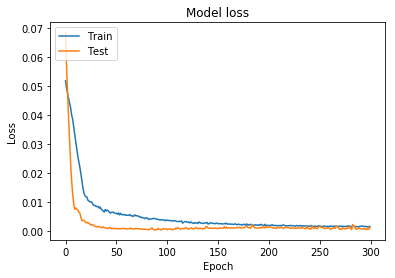

In [10]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

In [11]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.0027939377860026985 (40,) (40,)
[0.8486229  0.85078317 0.8553791  0.858932   0.8629442  0.86595607
 0.86516935 0.86533785 0.8654944  0.86540794 0.86621845 0.86676204
 0.86595416 0.8662877  0.86782897]
[0.80169067 0.83154956 0.83162707 0.84930971 0.84791377 0.77175426
 0.80161315 0.78354272 0.79416778 0.82115704 0.81906313 0.79548621
 0.8225531  0.85427325 0.85411811]
[212.55144 212.82999 213.42258 213.88069 214.39803 214.78638 214.68494
 214.70667 214.72684 214.7157  214.8202  214.89029 214.78613 214.82913
 215.02786]
[206.5        210.3500061  210.36000061 212.63999939 212.46000671
 202.63999939 206.49000549 204.16000366 205.52999878 209.00999451
 208.74000549 205.69999695 209.19000244 213.27999878 213.25999451]


NameError: name 'print_time' is not defined

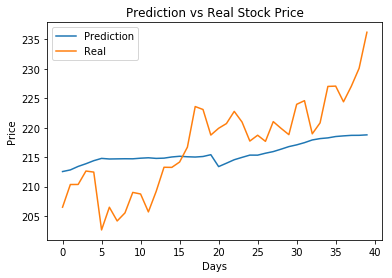

In [12]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
print_time("program completed ", stime)

In [ ]:
# is_update_model = True
# if model is None or is_update_model:
#     from keras import backend as K
#     print("Building model...")
#     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
#     model = create_model()
    
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
#                        patience=40, min_delta=0.0001)
    
#     mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
#                           "best_model.h5"), monitor='val_loss', verbose=1,
#                           save_best_only=True, save_weights_only=False, mode='min', period=1)

#     # Not used here. But leaving it here as a reminder for future
#     r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
#                                   verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
#     csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
#     history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
#                         shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                         trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
#     print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))

# # model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
# y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()
# y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])

# # convert the predicted value to range of real data
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the training data
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# # load the saved best model from above
# saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
# print(saved_model)

# y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()
# y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the prediction
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(y_pred_org)
# plt.plot(y_test_t_org)
# plt.title('Prediction vs Real Stock Price')
# plt.ylabel('Price')
# plt.xlabel('Days')
# plt.legend(['Prediction', 'Real'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
# print_time("program completed ", stime)